In [1]:
from collections import Counter, defaultdict
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
import itertools
import math
from pathlib import Path
from typing import List, Tuple, Union

from jupyterthemes import jtplot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils

from fastai.basic_data import DataBunch
from fastai.basic_train import Learner
from fastai.train import lr_find
from fastprogress import progress_bar

from utils import download_wikitext, prepare_data, load_glove
from nn_toolkit.vocab import Vocab, VocabEncoder

jtplot.style()
%load_ext autoreload
%matplotlib notebook
%autoreload 2

### Cooccurence Matrix

In [2]:
class Cooccurence:
    def __init__(self, vocab: Vocab, window: int, distance_mode: str, num_workers: int) -> None:
        self.vocab = vocab
        self.window = window
        self.distance_mode = distance_mode
        self.counts = defaultdict(lambda: defaultdict(float))
        self.num_workers = num_workers
        
    def dict_to_df(self):
        data = []
        for token1, token_counts in self.counts.items():
            for token2, count in token_counts.items():
                data.append({'token1': token1, 'token2': token2, 'count': count})
        df = pd.DataFrame(data)
        index = pd.MultiIndex.from_frame(df[['token1', 'token2']])
        return pd.DataFrame(df['count'].values, index=index, columns=['count'])

    def update(self, documents: List[List[str]]) -> None:
        with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
            futures = [executor.submit(self.add_doc, doc) for doc in documents]
            pbar = progress_bar(concurrent.futures.as_completed(futures), total=len(documents))
            for f in pbar:
                f.result()

    def add_doc(self, doc: List[str]) -> None:
        idx = 0
        while idx < len(doc):
            left = self.get_left_context(doc, idx)
            right = self.get_right_context(doc, idx)
            self.add_context(left, doc[idx], 'left')
            self.add_context(right, doc[idx], 'right')
            idx += 1
            assert len(self.counts) <= self.vocab.size

    def add_context(self, context: List[str], target: str, mode: str) -> None:
        if target not in self.vocab: target = '<unk>'
        for i, token in enumerate(context):
            if token not in self.vocab: token = '<unk>'
            d = (i + 1) if mode == 'right' else (self.window - i)
            self.counts[target][token] += self.distance_weight(d)
        return

    def get_right_context(self, doc: List[str], idx: int) -> List[str]:
        right_edge = min(len(doc), idx+self.window+1)
        right = doc[idx+1: right_edge]
        return right

    def get_left_context(self, doc: List[str], idx: int) -> List[str]:
        left_edge = max(0, idx-self.window)
        left = doc[left_edge: idx]
        return left

    def distance_weight(self, d: int):
        if self.distance_mode == 'inverse':
            return 1. / d
        return 1.

    def _get_from_str(self, key: str):
        return self.counts[key]

    def _get_from_int(self, key: int):
        key = self.vocab.int_to_token[key]
        return self._get_from_str(key)

    def __getitem__(self, key: Union[str, int]):
        if isinstance(key, int):
            return self._get_from_int(key)
        elif isinstance(key, str):
            return self._get_from_str(key)
        else:
            t = type(key)
            raise TypeError(f"Can not look up using type {t}")
            
    def get_sparse_Xij(self) -> torch.sparse.FloatTensor:
        rows = []
        cols = []
        vals = []
        for token1, count_dict in self.counts.items():
            for token2, v in count_dict.items():
                row, col = self.vocab[token1], self.vocab[token2]
                vals.append(v)
                rows.append(row)
                cols.append(col)
        assert len(rows) == len(cols)
        i = torch.tensor(list(zip(rows, cols))).t()
        vals = torch.tensor(vals)
        size = torch.Size([self.vocab.size, self.vocab.size])
        Xij = torch.sparse.FloatTensor(i, vals, size)
        return Xij

### Dataset

In [3]:
def softmax(x, dim=-1):
    b = x.max(dim)
    y = x - b
    return y / y.sum(dim)


class CooDataset(utils.data.Dataset):
    def __init__(self, coo: Cooccurence) -> None:
        self.coo = coo
        self.Xij = coo.dict_to_df()
        self.vocab = coo.vocab

    def __getitem__(self, idx: int):
        sample = self.Xij.iloc[idx]
        t1, t2 = sample.name
        i, j = self.vocab[t1], self.vocab[t2]
        xij = sample['count']
        return i, j, xij

    def __len__(self):
        return self.Xij.shape[0]

def collate_batch(batch) -> Tuple[torch.Tensor]:
    i = torch.LongTensor([sample[0] for sample in batch])  # (B,)
    j = torch.LongTensor([sample[1] for sample in batch])  # (B,)
    Xij = torch.FloatTensor([sample[-1] for sample in batch])  # (B,)
    return (i, j), Xij

### Model

In [74]:
class Glove(nn.Module):
    def __init__(self, vocab: Vocab, embedding_dim: int) -> None:
        super().__init__()
        self.vocab = vocab
        self.embedding_dim = embedding_dim
        lim = embedding_dim
        self.W = nn.Parameter(self._W_init())
        self.Wt = nn.Parameter(self._W_init())
        self.b = nn.Parameter(self._b_init())
        self.bt = nn.Parameter(self._b_init())

    def forward(self, i: torch.LongTensor, j: torch.LongTensor) -> torch.Tensor:
        wi = F.embedding(i, self.W, padding_idx=self.vocab.pad_index)  # (N, e)
        bi = F.embedding(i, self.b, padding_idx=self.vocab.pad_index).squeeze()  # (N,)
        wj = F.embedding(j, self.Wt, padding_idx=self.vocab.pad_index)  # (N, e)
        bj = F.embedding(j, self.bt, padding_idx=self.vocab.pad_index).squeeze()  # (N,)

        dot = (wi * wj).sum(1)  # (N,)
        p = dot + bi + bj
        return p

    def _W_init(self) -> torch.Tensor:
        size = [self.vocab.size, self.embedding_dim]
        W = torch.empty(*size).uniform_() - 0.5
        W = W / math.sqrt(self.embedding_dim)
        return W

    def _b_init(self) -> torch.Tensor:
        size = [self.vocab.size, 1]
        b = torch.empty(*size).uniform_() - 0.5
        b = b / math.sqrt(self.embedding_dim)
        return b

    def __getitem__(self, token: str):
        idx = self.vocab[token]
        return self.W[idx]

    def similarity(self, token1: str, token2: str) -> float:
        with torch.no_grad():
            vec1 = self[token1]
            vec2 = self[token2]
            norm = torch.norm(vec1) * torch.norm(vec2)
            dot = (vec1 * vec2).sum() / norm
        return dot.item()
    
    def analogy(self, token1: str, token2: str, token3: str, k: int = 5) -> str:
        with torch.no_grad():
            vec1 = self[token1]
            vec2 = self[token2]
            vec3 = self[token3]
            diff = vec1 - vec2 + vec3
            diff_norm = diff / torch.norm(diff)
            similarity  = self.W @ diff_norm / torch.norm(self.W)
            topk = torch.topk(similarity, k)
            idx = topk.indices.tolist()[0:k]
            vals = topk.values.tolist()[0:k]
        words = [self.vocab.get(i, reverse=True) for i in idx]
        return list(zip(words, vals))

    def most_similar(self, token: str, k: int = 10) -> List[Tuple[str, float]]:
        with torch.no_grad():
            vec = self[token].unsqueeze(0)  # (1, e)
            dot = (vec @ self.W.t()).squeeze()  # (N, )
            norm = torch.norm(vec, dim=1) * torch.norm(self.W, dim=1)
            norm = torch.clamp(norm, 1e-9, float('inf'))
            similarity = dot / norm
            topk = torch.topk(similarity, k)
        idxs = topk.indices.tolist()[0:k]
        vals = topk.values.tolist()[0:k]
        words = [self.vocab.get(i, reverse=True) for i in idxs]
        return list(zip(words, vals))

#### Loss

In [5]:
class GloveLoss(nn.modules.loss._Loss):
    """
    Weighted MSE summed, not averaged, over the vocabulary.
    
    Defaults are set to values in the paper.
    https://github.com/stanfordnlp/GloVe/blob/master/src/glove.c#L55
    https://nlp.stanford.edu/pubs/glove.pdf
    
    Parameters
    ----------
    xmax : int
        threshold to apply maximum weighting in the loss function, by default 100
    alpha : float
        power in weighting function, by default 0.75
    """

    def __init__(self, xmax: int = 100, alpha: float = 0.75) -> None:
        super().__init__()
        self.xmax = xmax
        self.alpha = alpha
        
    def forward(self, y_hat, Xij) -> torch.Tensor:
        w = self.f(Xij)
        mse = self.mse(y_hat, Xij)
        assert mse.size(0) == y_hat.size(0)
        return (w * mse).sum()
        
    def f(self, Xij:torch.LongTensor) -> torch.FloatTensor:
        w = Xij / self.xmax
        return torch.clamp(w, 0., 1.).pow(self.alpha)
    
    def mse(self, y_hat: torch.FloatTensor, Xij: torch.LongTensor) -> torch.FloatTensor:
        Xij = Xij.to(torch.float32)
        return F.mse_loss(y_hat, torch.log(Xij + 1.), reduction='none')

### Training

#### Load data

In [6]:
seed = 0
text_file = Path('data/raw/wikitext-2-v1.zip')
download_wikitext(text_file)

train_sents = prepare_data(text_file, mode='train', sampling_rate=1., seed=seed)
val_sents = prepare_data(text_file, mode='valid', sampling_rate=1., seed=seed)

train_tokens = Counter([t for sent in train_sents for t in sent])
max_vocab = 50000
vocab = Vocab([t for t, _ in train_tokens.most_common(max_vocab)])
print('Vocab size:', vocab.size)


Vocab size: 28914


In [7]:
window = 15
num_workers = 3
d_mode = 'inverse'

train_coo = Cooccurence(vocab=vocab, window=window, distance_mode=d_mode, num_workers=num_workers)
val_coo = Cooccurence(vocab=vocab, window=window, distance_mode=d_mode, num_workers=num_workers)
train_coo.update(train_sents)
val_coo.update(val_sents)

#### Create Dataset

In [ ]:
train_ds = CooDataset(train_coo)
val_ds = CooDataset(val_coo)

In [75]:
bs = 1024
pm = True

train_dl = utils.data.DataLoader(
    train_ds, batch_size=bs, shuffle=True, num_workers=num_workers, pin_memory=pm
)
val_dl = utils.data.DataLoader(
    val_ds, batch_size=bs, shuffle=False, num_workers=num_workers, pin_memory=pm
)

data = DataBunch(
    train_dl=train_dl, valid_dl=val_dl,
    collate_fn=collate_batch,
    device='cuda:0'
)

print('If distance mode is not inverse, the following values are the number of words.')
print('Total weight in train:', train_ds.Xij['count'].sum())
print('Total weight in val:', val_ds.Xij['count'].sum())

If distance mode is not inverse, the following values are the number of words.
Total weight in train: 9360292.48482075
Total weight in val: 974024.2906454646


#### Create model

In [76]:
model = Glove(vocab, 100)
model.to(data.device)
learner = Learner(
    data,
    model,
    loss_func=GloveLoss(xmax=100, alpha=0.75),
    opt_func=optim.Adam
)

#### Train model

In [77]:
lr_find(learner)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


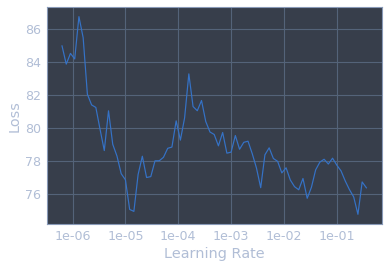

In [78]:
learner.recorder.plot()

In [ ]:
# glove code hyperparams
# lr = 0.05
# num_epochs = 25
# glove code uses lr of 0.05 
# https://github.com/stanfordnlp/GloVe/blob/master/src/glove.c
# that lr explodes my loss
# ~1e-6 behaves better
lr = 0.05
lr = 5e-6
epochs = 25
learner.fit(epochs, lr=lr)

epoch,train_loss,valid_loss,time


In [37]:
model.similarity('boy', 'ball')

0.13097161054611206

In [38]:
model.most_similar('king')

[('king', 1.0),
 ('santísima', 0.47828829288482666),
 ('communication', 0.4110476076602936),
 ('kept', 0.4006715416908264),
 ('octave', 0.3947133719921112),
 ('lyrics', 0.37999165058135986),
 ('1996', 0.3779255151748657),
 ('stout', 0.37716835737228394),
 ('extreme', 0.376064658164978),
 ('celebrate', 0.3751567006111145)]

In [39]:
model.most_similar('queen')

[('queen', 1.0),
 ('territories', 0.49280861020088196),
 ('denotes', 0.42824193835258484),
 ('clubs', 0.4246385991573334),
 ('authorized', 0.4214208424091339),
 ('pool', 0.4213694632053375),
 ('shown', 0.41974443197250366),
 ('remarks', 0.41296565532684326),
 ('international', 0.40919914841651917),
 ('lesbian', 0.40853914618492126)]

In [40]:
model.most_similar('girl')

[('girl', 1.0000001192092896),
 ('daughter', 0.6950398683547974),
 ('081', 0.6156168580055237),
 ('processed', 0.5929248332977295),
 ('slip', 0.5840063691139221),
 ('confirms', 0.5839430689811707),
 ('dad', 0.5629984736442566),
 ('youngsters', 0.5615664124488831),
 ('fighters', 0.5591626167297363),
 ('turboprop', 0.553156316280365)]

In [41]:
model.most_similar('boy')

[('boy', 1.000000238418579),
 ('cruise', 0.4701233506202698),
 ('examinations', 0.4626637399196625),
 ('zuzanna', 0.453369677066803),
 ('exhaust', 0.43963807821273804),
 ('marlow', 0.4308280050754547),
 ('recalled', 0.42248257994651794),
 ('review', 0.41422948241233826),
 ('evening', 0.4132612347602844),
 ('gaps', 0.4085180461406708)]

In [43]:
model.analogy('boy', 'man', 'woman')

[('toyline', 3.158550977706909),
 ('wolf', 3.1302003860473633),
 ('esarhaddon', 3.008922576904297),
 ('boos', 2.8797550201416016),
 ('sarsen', 2.877915382385254)]

### Pretrained glove

In [60]:
tokens, W = load_glove('data/glove/glove.6B.100d.txt')
glove_vocab = Vocab(tokens, add_specials=False)

In [61]:
glove = Glove(glove_vocab, W.size(1))

In [62]:
glove.most_similar('king')

[('king', 0.9999998807907104),
 ('presov', 0.47020792961120605),
 ('diniyar', 0.4319826066493988),
 ('xiqing', 0.42202600836753845),
 ('43-year-old', 0.4142630994319916),
 ('119.36', 0.41008949279785156),
 ('step-father', 0.4088504910469055),
 ('cryptogram', 0.407711386680603),
 ('masnadieri', 0.39987653493881226),
 ('218', 0.39969319105148315)]

In [63]:
glove.most_similar('queen')

[('queen', 1.0000001192092896),
 ('1.446', 0.475906103849411),
 ('manber', 0.4549559950828552),
 ('oakmont', 0.42867404222488403),
 ('prichard', 0.42549237608909607),
 ('winterfest', 0.41983669996261597),
 ('nyala', 0.41780614852905273),
 ('slowdown', 0.40534621477127075),
 ('carroll', 0.39995071291923523),
 ('nebraskan', 0.39841365814208984)]

In [64]:
glove.most_similar('girl')

[('girl', 0.9999997019767761),
 ('satine', 0.46418696641921997),
 ('woodgrain', 0.43411779403686523),
 ('pocho', 0.4268955886363983),
 ('euroatlantic', 0.42448511719703674),
 ('gerashchenko', 0.42178109288215637),
 ('hamate', 0.4123415946960449),
 ('non-chalcedonian', 0.4062996208667755),
 ('rachis', 0.401823490858078),
 ('kaneto', 0.4004417061805725)]

In [65]:
glove.most_similar('boy')

[('boy', 0.9999999403953552),
 ('nordbaden', 0.4301069378852844),
 ('tring', 0.42962849140167236),
 ('hopefuls', 0.42075690627098083),
 ('sainte-victoire', 0.41124171018600464),
 ('warnecke', 0.40438613295555115),
 ('cherri', 0.39648669958114624),
 ('bloor', 0.39353007078170776),
 ('aldrich', 0.3854254484176636),
 ('vlaardingen', 0.38521912693977356)]

In [66]:
glove.analogy('king', 'queen', 'man')

[('man', 0.0011205320479348302),
 ('king', 0.0008881384273990989),
 ('manganate', 0.0007245009182952344),
 ('dummerston', 0.0006804452277719975),
 ('seracini', 0.0006758874515071511)]

In [73]:
torch.norm(glove[''])

tensor(0.0293, grad_fn=<NormBackward0>)